## wikipedia api
wikipedia api는 위키피디아 문서들을 일일이 크롤링하지 않아도 쉽게 접근할 수 있게끔 하는 api로서 작동 방법 역시 간편하다.

In [ ]:
!pip install wikipedia-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


NameError: ignored

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 56.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wikipediaapi
import pandas as pd
import re
from konlpy.tag import Okt
#okt = Okt()
#with open('/content/drive/MyDrive/sentence/stopwords.txt',  encoding='cp949') as f:
#    list_file = f.readlines()
#    stopwords = list_file[0].split(",")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.models import LdaModel
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
wiki=wikipediaapi.Wikipedia('ko') # 한글 버전으로 변경

## transformers 모듈 설치 및 허깅페이스에서 모델 불러오기

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration

digit_tokenizer = PreTrainedTokenizerFast.from_pretrained('digit82/kobart-summarization')
digit_model = BartForConditionalGeneration.from_pretrained('digit82/kobart-summarization')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
gogamza_tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-summarization')
gogamza_model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-summarization')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
ainize_tokenizer = PreTrainedTokenizerFast.from_pretrained('ainize/kobart-news')
ainize_model = BartForConditionalGeneration.from_pretrained('ainize/kobart-news')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


## Kukipedia 소개

In [ ]:
class Kukipedia():

  def __init__(self, target_title):
    self.section_dict = {}
    self.target_title = target_title
    self.model_dict = {'digit': self.digit,
                  'gogamza': self.gogamza,
                  'ainize': self.ainize}


  def sections_dict(self, sections):
    """
    섹션들을 딕셔너리로 모아주는 함수
    """
    for s in sections:
      self.section_dict[s.title] = s.text
      self.sections_dict(s.sections)
    return self.section_dict


  def del_unnecessary_section(self, dictionary):
    """
    섹션 중에는 내용이 없는 것도 있고, 외부링크, 같이보기처럼 쓸모 없는 것도 있다. 
    그러한 섹션은 요약이 무의미하니 삭제하는 함수
    """
    no_contents = []
    reference_etc_list = ['각주', '같이 보기', '외부 링크'] # 요약의 효용이 없는 섹션
    for i in dictionary.keys():
      if not bool(dictionary[i]):
        no_contents.append(i)
      elif i in reference_etc_list:
        no_contents.append(i)
    for j in no_contents:
      del dictionary[j]
    return dictionary


  def make_wordcloud_entire(self, backgroundcolor='white', width=600, height=400):
    """
    문서 전체의 텍스트로 워드클라우드 만드는 함수
    요약문으로 워드클라우드 만드는 함수(make_wordcloud)보다 체감상 성능이 우수
    """
    target_page = wiki.page(self.target_title)
    entire_text = target_page.text
    corpus = self.preprocess_text(entire_text)
    wordcloud = WordCloud(font_path = '/content/drive/MyDrive/sentence/MALGUN.TTF', 
                          background_color = backgroundcolor, 
                          width = width, 
                          height = height).generate(corpus)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


  def get_url(self):
    """
    문서의 url을 출력해주는 함수
    """
    target_page = wiki.page(self.target_title)
    print("[{}] 문서의 url주소: {}".format(self.target_title, target_page.fullurl))


  def digit(self, text, num_beams=4, length_penalty=1.0, max_length=512):
    """
    digit82_KoBART 모델로 요약하는 함수
    Args:
      text (str): 요약 대상 원문 텍스트
      num_beams (int): beam search에 사용할 시퀀스 개수
      length_penalty (float): 요약문의 길이에 영향을 주는 가중치
      max_length (int): 요약문 토큰의 최대 길이
    Returns:
      result: 요약 결과물
    """
    raw_input_ids = digit_tokenizer.encode(text) # 토큰화, 정수 인코딩
    raw_input_ids = raw_input_ids[:1022] # KoBART 토큰 길이 제한 맞추기
    input_ids = [digit_tokenizer.bos_token_id] + raw_input_ids + [digit_tokenizer.eos_token_id] # bos, eos 토큰 추가
    summary_ids = digit_model.generate(torch.tensor([input_ids]), 
                                       num_beams=num_beams, 
                                       max_length=max_length, 
                                       length_penalty=length_penalty, 
                                       eos_token_id=1)
    result = digit_tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)
    return result


  def gogamza(self, text, num_beams=4, length_penalty=1.0, max_length=512):
    """
    gogamza_KoBART 모델로 요약하는 함수
    """
    raw_input_ids = gogamza_tokenizer.encode(text) # 토큰화, 정수 인코딩
    raw_input_ids = raw_input_ids[:1022] # KoBART 토큰 길이 제한 맞추기
    input_ids = [gogamza_tokenizer.bos_token_id] + raw_input_ids + [gogamza_tokenizer.eos_token_id] # bos, eos 토큰 추가
    summary_ids = gogamza_model.generate(torch.tensor([input_ids]), 
                                         num_beams=num_beams, 
                                         max_length=max_length, 
                                         length_penalty=length_penalty, 
                                         eos_token_id=1)
    result = gogamza_tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)
    return result


  def ainize(self, text, num_beams=4, length_penalty=1.0, max_length=512):
    """
    ainize_KoBART 모델로 요약하는 함수
    """
    input_ids = ainize_tokenizer.encode(text)
    input_ids = input_ids[1:len(input_ids)-1] # KoBART 토큰 길이 제한 맞추기
    input_ids = [ainize_tokenizer.bos_token_id] + input_ids[:1022] + [ainize_tokenizer.eos_token_id] # 토큰화, 정수 인코딩, torch 자료형으로 변경
    summary_ids = ainize_model.generate(torch.tensor([input_ids]), 
                                        num_beams=num_beams, 
                                        max_length=max_length, 
                                        length_penalty=length_penalty, 
                                        eos_token_id=1)
    result = ainize_tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)
    return result


  def wiki_summary_outline(self, summary_model, num_beams=4, length_penalty=1.0, max_length=512):
    """
    문서의 개요 부분을 요약하는 함수
    """
    target_page = wiki.page(self.target_title)
    if target_page.exists():
      model = self.model_dict[summary_model]
      text = target_page.summary
      result = model(text, num_beams, length_penalty, max_length)

    else:
      result = "[{}](이)라는 이름의 문서는 위키피디아에 존재하지 않습니다".format(self.target_title)

    return result


  def wiki_summary_section(self, summary_model, num_beams=4, length_penalty=1.0, max_length=512):
    """
    원하는 섹션 하나 골라 요약해주는 함수
    """
    model = self.model_dict[summary_model]
    target_page = wiki.page(self.target_title)

    if target_page.exists(): # 문서가 존재할 경우만 요약
      section_collection = self.sections_dict(target_page.sections)
      section_collection = self.del_unnecessary_section(section_collection)

      print(section_collection.keys())
      target_key = input('위의 keys 중 요약을 원하는 섹션을 따옴표 없이 정확히 입력해주세요 : ')
      if target_key in section_collection.keys():
        text = section_collection[target_key]
        result = model(text, num_beams, length_penalty, max_length)
      else:
        result = "[{}](이)라는 이름의 섹션은 [{}] 문서에 존재하지 않습니다.".format(target_key, self.target_title)

    else: # 문서가 존재하지 않으면 아래 문구 출력
      result = "[{}](이)라는 이름의 문서는 위키피디아에 존재하지 않습니다".format(self.target_title)

    return result


  def wiki_summary_combine(self, summary_model, num_beams=4, length_penalty=1.0, 
                           max_length=512, return_dict=False):
    """
    세션을 각각 요약한 것을 하나로 합쳐주는 함수
    """
    model = self.model_dict[summary_model]
    target_page = wiki.page(self.target_title)

    if target_page.exists(): # 문서가 존재할 경우만 요약
      section_collection = self.sections_dict(target_page.sections)
      section_collection = self.del_unnecessary_section(section_collection)
      summary_dict = {}
      for k in section_collection.keys():
        text = section_collection[k]
        summary = model(text, num_beams, length_penalty, max_length)
        summary_dict[k] = summary
      summary_dict_collect = summary_dict

      if return_dict: # return_dict=True인 경우 딕셔너리 형태로 반환
        result = summary_dict_collect

      else: # 개행된 문자열로 출력
        result = ""
        for i, j in enumerate(summary_dict_collect.keys()):
          result += "# section [{}]: [{}] \n    - summary: {} \n\n".format(i, j, 
                                                                           summary_dict_collect[j])

    else: # 문서가 존재하지 않으면 아래 문구 출력
      result = "[{}](이)라는 이름의 문서는 위키피디아에 존재하지 않습니다".format(self.target_title)

    return result


  def preprocess_text(self, text):
    """
    워드클라우드, 토픽모델링을 위해 전처리해주는 함수
    """
    okt = Okt()
    with open('/content/drive/MyDrive/sentence/stopwords.txt',  encoding='cp949') as f:
      list_file = f.readlines()
      stopwords = list_file[0].split(",")

    only_korean = re.sub('[^가-힣]', ' ', text)
    spaced_text = ' '.join(only_korean.split())
    morph_text = okt.morphs(spaced_text, stem=True)
    lenght_two = [x for x in morph_text if len(x)>1]
    nonstopwords = [x for x in lenght_two if x not in stopwords]
    corpus = ' '.join(nonstopwords)
    return corpus

  def make_wordcloud(self, summary_model, num_beams=4, length_penalty=1.0, max_length=512, 
                     backgroundcolor='white', width=600, height=400):
    """
    요약문을 토대로 워드클라우드를 만드는 함수
    """
    summary_dict = self.wiki_summary_combine(summary_model=summary_model,
                                     num_beams=num_beams,
                                     length_penalty=length_penalty,
                                     max_length=max_length,
                                     return_dict=True)
    entire_text = ' '.join(summary_dict.values())
    corpus = self.preprocess_text(entire_text)
    wordcloud = WordCloud(font_path = '/content/drive/MyDrive/sentence/MALGUN.TTF', 
                          background_color = backgroundcolor, 
                          width = width, 
                          height = height).generate(corpus)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


  def compute_coherence_values(self, dictionary, corpus, texts, limit=15, start=2, step=3):
    """
    토픽모델링을 하기 앞서 최적의 토픽 개수를 찾아주는 함수
    """
    coherence_values = {}
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values[num_topics] = coherencemodel.get_coherence()

    return max(coherence_values, key=coherence_values.get)


  def topic_modeling(self, summary_model, num_beams=4, length_penalty=1.0, max_length=512):
      """
      요약문을 토대로 토픽 모델링을 진행하는 함수
      """
      summary_dict = self.wiki_summary_combine(summary_model=summary_model,
                                     num_beams=num_beams,
                                     length_penalty=length_penalty,
                                     max_length=max_length,
                                     return_dict=True)
      preprocessed = []
      for text in summary_dict.values():
        preprocessed.append(self.preprocess_text(text).split())
      dic = gensim.corpora.Dictionary(preprocessed)
      bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
      NUM_TOPICS = self.compute_coherence_values(dic, bow_corpus, preprocessed)
      lda_model =  gensim.models.LdaModel(bow_corpus, 
                                num_topics = NUM_TOPICS, 
                                id2word = dic,                                    
                                passes = 10)
      pyLDAvis.enable_notebook()
      vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
      return vis

  def topic_modeling_entire(self):
    """
    문서 전체를 토대로 토픽 모델링을 진행하는 함수
    """
    target_page = wiki.page(self.target_title)

    if target_page.exists(): # 문서가 존재할 경우만 요약
      section_collection = self.sections_dict(target_page.sections)
      section_collection = self.del_unnecessary_section(section_collection)
      preprocessed = []
      for text in section_collection.values():
        preprocessed.append(self.preprocess_text(text).split())
      dic = gensim.corpora.Dictionary(preprocessed)
      bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
      NUM_TOPICS = self.compute_coherence_values(dic, bow_corpus, preprocessed)
      lda_model =  gensim.models.LdaModel(bow_corpus, 
                                num_topics = NUM_TOPICS, 
                                id2word = dic,                                    
                                passes = 10)
      pyLDAvis.enable_notebook()
      result = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)

    else: # 문서가 존재하지 않으면 아래 문구 출력
      result = "[{}](이)라는 이름의 문서는 위키피디아에 존재하지 않습니다".format(self.target_title)
      
    return result


In [ ]:
help(Kukipedia)

Help on class Kukipedia in module __main__:

class Kukipedia(builtins.object)
 |  Kukipedia(target_title)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, target_title)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ainize(self, text, num_beams=4, length_penalty=1.0, max_length=512)
 |      ainize_KoBART 모델로 요약하는 함수
 |  
 |  compute_coherence_values(self, dictionary, corpus, texts, limit=15, start=2, step=3)
 |      토픽모델링을 하기 앞서 최적의 토픽 개수를 찾아주는 함수
 |  
 |  del_unnecessary_section(self, dictionary)
 |      섹션 중에는 내용이 없는 것도 있고, 외부링크, 같이보기처럼 쓸모 없는 것도 있다. 
 |      그러한 섹션은 요약이 무의미하니 삭제하는 함수
 |  
 |  digit(self, text, num_beams=4, length_penalty=1.0, max_length=512)
 |      digit82_KoBART 모델로 요약하는 함수
 |  
 |  get_url(self)
 |      문서의 url을 출력해주는 함수
 |  
 |  gogamza(self, text, num_beams=4, length_penalty=1.0, max_length=512)
 |      gogamza_KoBART 모델로 요약하는 함수
 |  
 |  make_wordcloud(self, summary_model, num_beams=4, length_penalty=1.0, max_length=512, b

### 1. 요약을 원하는 문서명 입력

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")

In [ ]:
# 존재하지 않는 문서명 입력 시에는
kuki = Kukipedia(target_title = "이런이름의문서는없다")
kuki.wiki_summary_outline('ainize')

'[이런이름의문서는없다](이)라는 이름의 문서는 위키피디아에 존재하지 않습니다'

### 2. get_url()
입력한 문서의 url을 출력해주는 함수이다.

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.get_url()

[고려대학교] 문서의 url주소: https://ko.wikipedia.org/wiki/%EA%B3%A0%EB%A0%A4%EB%8C%80%ED%95%99%EA%B5%90


### 3. wiki_summary_outline(summary_model)

문서 최상단에 있는 '개요' 부분을 요약해주는 함수이다.

- `summary_model`: `gogamza`, `digit`, `ainize` 모델 중 택 1
- `num_beams`: n개의 확률 값이 높은 단어를 선택하기 위한 파라미터(default=4)
- `length_penalty`: 1보다 작은 경우 짧은 문장 생성 유도, 1보다 클 경우 더 긴 문장 생성 유도(default=1.0)
- `max_length`: 요약문의 최대 길이(default=512)

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_outline(summary_model='ainize',
                          num_beams=4,
                          length_penalty=1.2,
                          max_length=512)

'독제 정권에 항거하여 1960년 4·19 혁명의 촉매제가 된 4·18 의거를 비롯한 각종 시위의 중심에 서기도 했던 고려대학교는 1946년 종합대학으로 승격하여 고려대학교로 개칭하였으며, 1952년 12월에는 문과대학을 문리과대학으로 개편하고 1971년에는 우석대학교 의과대학을 흡수 합병해 이공·인문·의예·예체능 관련 학과를 고루 갖추게 됐다.'

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_outline('gogamza')

'대한민국의 사립 종합대학인 고려대학교는 1960년 4·19 혁명의 촉매제가 된 4·18 의거를 비롯한 각종 시위의 중심에 서기도 했다.'

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_outline(summary_model='digit',
                          num_beams=4,
                          length_penalty=1.2,
                          max_length=512)

'대한민국의 사립 종합대학인 고려대학교(高麗大學校, 영어: Korea University, KU)는 한국 최초의 민간인에 의한 근대 고등교육기관 보성전문학교(普成專門學校)로 출발하였으며 1960년 4·19 혁명의 촉매제가 된 4·18 의거를 비롯한 각종 시위의 중심에 서기도 하였다.'

In [ ]:
kuki = Kukipedia(target_title = "손흥민")
kuki.wiki_summary_outline('gogamza')

'대한민국 축구 국가대표팀의 주장이자 2018년 아시안 게임 금메달리스트인 손흥민은 현재 잉글랜드 프리미어리그 토트넘 홋스퍼에서 윙어로 활약하고 있으며 2018년 아시안 게임 금메달리스트이며 영국에서는 애칭인 "쏘니"(Sonny)로 불린다.'

### 4. wiki_summary_section(summary_model)

문서에는 여러 가지 하위 섹션이 있다. 이 섹션 중 원하는 섹션을 입력하면 그 섹션만 요약해주는 함수이다.

- `summary_model`: `gogamza`, `digit`, `ainize` 모델 중 택 1
- `num_beams`: n개의 확률 값이 높은 단어를 선택하기 위한 파라미터(default=4)
- `length_penalty`: 1보다 작은 경우 짧은 문장 생성 유도, 1보다 클 경우 더 긴 문장 생성 유도(default=1.0)
- `max_length`: 요약문의 최대 길이(default=512)

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_section('digit')

dict_keys(['고려대학교의 모태', '종합대학으로의 승격과 우석대학교 의과대학의 흡수·합병', '반복적인 시위와 잦은 휴교 사태', '교육시설의 확충', '졸업요건의 변화', '개교 100주년 기념사업', '세계 대학 순위 평가', '세계 대학 평가 기관', '최근의 세계 대학 평가 결과', '개설 학과·전공', '학부 과정', '대학원 과정', '국제 교류', 'Global KU 프로젝트와 한자졸업요건', '제2 전공의 의무화', '캠퍼스 및 학교 소유 시설', '인문·사회계 캠퍼스', '자연계(이공계) 캠퍼스', '녹지 캠퍼스', '정릉캠퍼스', '세종캠퍼스(분교)', '의료원 및 기타 시설', '서울캠퍼스 주변 상권', '총학생회', '학내 공식 언론단체', '동아리', '기타', '사발식', '동아리 박람회', '4·18 기념 마라톤과 구국 대장정', '석탑대동제', '입실렌티 지·야의 함성', '고연전', '운동부', '교우회 및 동문'])
위의 keys 중 요약을 원하는 섹션을 따옴표 없이 정확히 입력해주세요 : 반복적인 시위와 잦은 휴교 사태


'1960년 4월 11일 3·15 부정선거와 관련된 마산 시위에서 실종된 김주열의 시신이 마산 앞바다에서 발견된 것과 관련하여 5개 단과대학 운영위원장들의 주도로 수많은 학생들이 ‘마산사건의 책임자를 즉시 처단’할 것을 요구하면서 장외시위를 벌였으나, 돌아오는 길에 신도환의 대한반공청년단 소속 폭력배들에게 피습을 당하여 4·19 혁명의 도화선이 됐다.'

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_section('ainize',
                          num_beams=5)

dict_keys(['고려대학교의 모태', '종합대학으로의 승격과 우석대학교 의과대학의 흡수·합병', '반복적인 시위와 잦은 휴교 사태', '교육시설의 확충', '졸업요건의 변화', '개교 100주년 기념사업', '세계 대학 순위 평가', '세계 대학 평가 기관', '최근의 세계 대학 평가 결과', '개설 학과·전공', '학부 과정', '대학원 과정', '국제 교류', 'Global KU 프로젝트와 한자졸업요건', '제2 전공의 의무화', '캠퍼스 및 학교 소유 시설', '인문·사회계 캠퍼스', '자연계(이공계) 캠퍼스', '녹지 캠퍼스', '정릉캠퍼스', '세종캠퍼스(분교)', '의료원 및 기타 시설', '서울캠퍼스 주변 상권', '총학생회', '학내 공식 언론단체', '동아리', '기타', '사발식', '동아리 박람회', '4·18 기념 마라톤과 구국 대장정', '석탑대동제', '입실렌티 지·야의 함성', '고연전', '운동부', '교우회 및 동문'])
위의 keys 중 요약을 원하는 섹션을 따옴표 없이 정확히 입력해주세요 : 고연전


'고연전은 연희전문학교와 연희학교의 전신인 연희전문학교가 1925년 5월 30일에 열린 조선체육회 주최 ‘제5회 전조선(全朝鮮) 정구대회’에서 처음으로 맞붙어 애교심을 고양하고 고려대학교와 연세대학교 양교의 친선을 도모하기 위한 목적으로 스포츠 경기를 비롯한 강연, 온라인 게임, 사회공헌활동과 같은 다양한 분야에서 연세대학교와 승부를 겨루는 행사 일체를 의미하지만 정식 명칭은 실질적으로 방송 중계나 신문 보도 등의 공식 석상에만 사용될 뿐이며, 고려대학교에서는 고연전, 연세대학교에서는 연고전이라는 명칭으로 통용된다.'

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_section('digit')

dict_keys(['고려대학교의 모태', '종합대학으로의 승격과 우석대학교 의과대학의 흡수·합병', '반복적인 시위와 잦은 휴교 사태', '교육시설의 확충', '졸업요건의 변화', '개교 100주년 기념사업', '세계 대학 순위 평가', '세계 대학 평가 기관', '최근의 세계 대학 평가 결과', '개설 학과·전공', '학부 과정', '대학원 과정', '국제 교류', 'Global KU 프로젝트와 한자졸업요건', '제2 전공의 의무화', '캠퍼스 및 학교 소유 시설', '인문·사회계 캠퍼스', '자연계(이공계) 캠퍼스', '녹지 캠퍼스', '정릉캠퍼스', '세종캠퍼스(분교)', '의료원 및 기타 시설', '서울캠퍼스 주변 상권', '총학생회', '학내 공식 언론단체', '동아리', '기타', '사발식', '동아리 박람회', '4·18 기념 마라톤과 구국 대장정', '석탑대동제', '입실렌티 지·야의 함성', '고연전', '운동부', '교우회 및 동문'])
위의 keys 중 요약을 원하는 섹션을 따옴표 없이 정확히 입력해주세요 : 고연전


'애교심을 고양하고 고려대학교와 연세대학교 양교의 친선을 도모하기 위해 매년 9월에 연세대학교 5개 종목의 운동부 선수들과 맞붙는 ‘정기 고연전’ 과 정기 고연전 이외의 기간에 열리는 ‘비정기 고연전’으로 나누어볼 수 있다.'

In [ ]:
kuki = Kukipedia(target_title = "손흥민")
kuki.wiki_summary_section('ainize')

dict_keys(['학력', '초기 생애', '2010-11 시즌', '2011-12 시즌', '2013-14 시즌', '2014-15 시즌', '2015-16 시즌', '2016-17 시즌', '2017-18 시즌', '2018-19 시즌', '2019-20 시즌', '2020-21 시즌', '2021-22 시즌', '2022-23 시즌', '국가대표팀 경력', '주요 출전 국제대회', '대회 기록', '개인', '대한민국 정부', '클럽', '국가대표팀 주요 국제대회 참가 기록', '국가대표팀 득점 기록', '광고', '평판', '기타'])
위의 keys 중 요약을 원하는 섹션을 따옴표 없이 정확히 입력해주세요 : 초기 생애


'함92년 7월 8일 손흥민은 강원도 춘천시 후평동에서 아버지 손웅정과 어머니 길은자의 차남으로 태어나 그곳에서 자라 막노동을 했다고 할 정도로 집안 환경이 좋지 않아 학업에 열중은 못했으나 축구선수였던 아버지의 영향으로 유전적으로 축구에 재능이 있어 매일 10시간 이상을 땀을 흘려 축구 연습에만 매진했다고 회고했다.'

In [ ]:
# 존재하지 않는 섹션명을 입력할 경우
kuki = Kukipedia(target_title = "고려대학교")
kuki.wiki_summary_section('digit')

dict_keys(['고려대학교의 모태', '종합대학으로의 승격과 우석대학교 의과대학의 흡수·합병', '반복적인 시위와 잦은 휴교 사태', '교육시설의 확충', '졸업요건의 변화', '개교 100주년 기념사업', '세계 대학 순위 평가', '세계 대학 평가 기관', '최근의 세계 대학 평가 결과', '개설 학과·전공', '학부 과정', '대학원 과정', '국제 교류', 'Global KU 프로젝트와 한자졸업요건', '제2 전공의 의무화', '캠퍼스 및 학교 소유 시설', '인문·사회계 캠퍼스', '자연계(이공계) 캠퍼스', '녹지 캠퍼스', '정릉캠퍼스', '세종캠퍼스(분교)', '의료원 및 기타 시설', '서울캠퍼스 주변 상권', '총학생회', '학내 공식 언론단체', '동아리', '기타', '사발식', '동아리 박람회', '4·18 기념 마라톤과 구국 대장정', '석탑대동제', '입실렌티 지·야의 함성', '고연전', '운동부', '교우회 및 동문'])
위의 keys 중 요약을 원하는 섹션을 따옴표 없이 정확히 입력해주세요 : 알 수 없는 섹션


'[알 수 없는 섹션](이)라는 이름의 섹션은 [고려대학교] 문서에 존재하지 않습니다.'

### 5. wiki_summary_combine(summary_model)

각 섹션을 일일이 요약한 후 요약문을 하나로 합쳐서 일괄적으로 보여주는 함수이다.

- `summary_model`: `gogamza`, `digit`, `ainize` 모델 중 택 1
- `num_beams`: n개의 확률 값이 높은 단어를 선택하기 위한 파라미터(default=4)
- `length_penalty`: 1보다 작은 경우 짧은 문장 생성 유도, 1보다 클 경우 더 긴 문장 생성 유도(default=1.0)
- `max_length`: 요약문의 최대 길이(default=512)

- `return_dict`를 `True`로 설정하면 딕셔너리 형태로 반환. `False`인 경우엔 개행된 문자열 형태로 출력(default=False)

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
wiki_summary_combine = kuki.wiki_summary_combine('ainize')
print(wiki_summary_combine)

# section [0]: [고려대학교의 모태] 
    - summary: 고려대학교의 모태는 대한제국 내장원경 이용익이 1905년에 대한제국 내장원경 이용익이 1905년에 대한제국 내장원경 이용익이 1905년에 설립한 보성전문학교로, 1932년 동아일보 창업자 김성수가 학교를 인수했고 1934년에는 안암동의 현재의 자리로 학교를 옮겼다가 1944년 일제에 의해 학교 이름이 경성척식경제전문학교로 변경됐다. 

# section [1]: [종합대학으로의 승격과 우석대학교 의과대학의 흡수·합병] 
    - summary: 1945년 해방 후 1945년 해방 후 교명을 보성전문학교로 환원하고, 1946년에 고려대학교로 개칭됐으며 1946년에 종합대학으로의 설립이 인가되고, 1946년에 본교는 애기능 인근 부지를 매입하였으며 1946년에 이공계캠퍼스가 자리 잡는 기반이 된다. 

# section [2]: [반복적인 시위와 잦은 휴교 사태] 
    - summary: 독60년 4월 11일 3·15 부정선거와 관련된 마산 시위에서 실종된 김주열의 시신이 마산 앞바다에서 발견된 것과 관련하여 수많은 학생들이 ‘마산사건의 책임자를 즉시 처단’할 것을 요구하면서 장외시위를 벌였으나, 돌아오는 길에 신도환의 대한반공청년단 소속 폭력배들에게 피습을 당하여 4·19 혁명의 도화선이 되고 독재정권에 맞선 선배들의 정의로운 행동을 계승하기 위해 ‘4·18 구국대장정’ 행사가 매년 4월 18일에 열린다. 

# section [3]: [교육시설의 확충] 
    - summary: 1945년 신관을 신축하여 1978년 3월에 개관한 중앙도서관 구관이 1935년에 착공하여 1937년에 개관한 데 이어 1975년에는 창립 70주년을 기념하기 위해 중앙도서관 신관을 신축하여 1978년 3월에 개관하였으며 한편 수도권 인구분산 정책에 따라 조치원분교 설립이 인가됐는데 이것이 현재의 세종캠퍼스가 탄생하는 밑거름이 됐다. 

# section [4]: [졸업요건의 변화] 
    - sum

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
wiki_summary_combine_dict = kuki.wiki_summary_combine('ainize', 
                                                      return_dict=True) # 결과를 딕셔너리 형태로 반환한다. 디폴트값은 False.
print(wiki_summary_combine_dict)

{'고려대학교의 모태': '고려대학교의 모태는 대한제국 내장원경 이용익이 1905년에 대한제국 내장원경 이용익이 1905년에 대한제국 내장원경 이용익이 1905년에 설립한 보성전문학교로, 1932년 동아일보 창업자 김성수가 학교를 인수했고 1934년에는 안암동의 현재의 자리로 학교를 옮겼다가 1944년 일제에 의해 학교 이름이 경성척식경제전문학교로 변경됐다.', '종합대학으로의 승격과 우석대학교 의과대학의 흡수·합병': '1945년 해방 후 1945년 해방 후 교명을 보성전문학교로 환원하고, 1946년에 고려대학교로 개칭됐으며 1946년에 종합대학으로의 설립이 인가되고, 1946년에 본교는 애기능 인근 부지를 매입하였으며 1946년에 이공계캠퍼스가 자리 잡는 기반이 된다.', '반복적인 시위와 잦은 휴교 사태': '독60년 4월 11일 3·15 부정선거와 관련된 마산 시위에서 실종된 김주열의 시신이 마산 앞바다에서 발견된 것과 관련하여 수많은 학생들이 ‘마산사건의 책임자를 즉시 처단’할 것을 요구하면서 장외시위를 벌였으나, 돌아오는 길에 신도환의 대한반공청년단 소속 폭력배들에게 피습을 당하여 4·19 혁명의 도화선이 되고 독재정권에 맞선 선배들의 정의로운 행동을 계승하기 위해 ‘4·18 구국대장정’ 행사가 매년 4월 18일에 열린다.', '교육시설의 확충': '1945년 신관을 신축하여 1978년 3월에 개관한 중앙도서관 구관이 1935년에 착공하여 1937년에 개관한 데 이어 1975년에는 창립 70주년을 기념하기 위해 중앙도서관 신관을 신축하여 1978년 3월에 개관하였으며 한편 수도권 인구분산 정책에 따라 조치원분교 설립이 인가됐는데 이것이 현재의 세종캠퍼스가 탄생하는 밑거름이 됐다.', '졸업요건의 변화': '2000년대에 들어서자 세계화 되는 추세에서 고려대학교 졸업자의 실력은 세계적인 수준에 맞추어야 한다는 ‘Global KU 프로젝트’ 등의 영향으로 졸업요건이 대폭 강화되는 등의 변화가 있었고, 2004년 3월 신입생부터는 한자 2급 수준의 졸업요

### 6. make_wordcloud(summary_model, backgroundcolor, width, height)

`wiki_summary_combine()` 함수로 요약된 결과물을 워드클라우드로 표현해주는 함수이다.

- `backgroundcolor`: 워드클라우드의 배경색 지정(default='white')
- `width`: 워드클라우드의 가로 길이 지정(default=600)
- `height`: 워드클라우드의 세로 길이 지정(default=400)

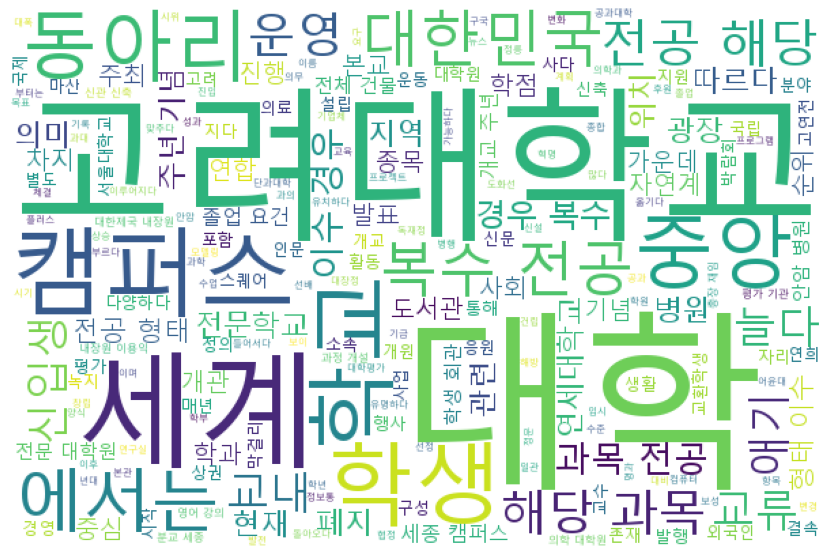

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.make_wordcloud('ainize', backgroundcolor='white', width=600, height=400)

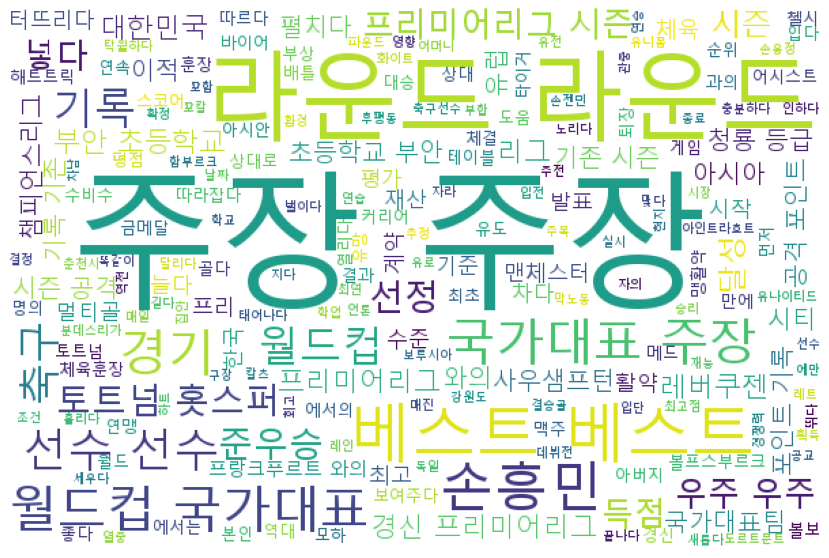

In [ ]:
kuki = Kukipedia(target_title = "손흥민")
kuki.make_wordcloud('ainize', backgroundcolor='white', width=600, height=400)

그런데 요약문을 워드클라우드로 나타내는 것보다 요약 안 된 전체 텍스트를 워드클라우드하는 게 더 나은 것 같긴 하다.

`make_wordcloud_entire`은 요약 안하고 원본 전체 텍스트를 워드클라우드로 나타내는 함수이다.

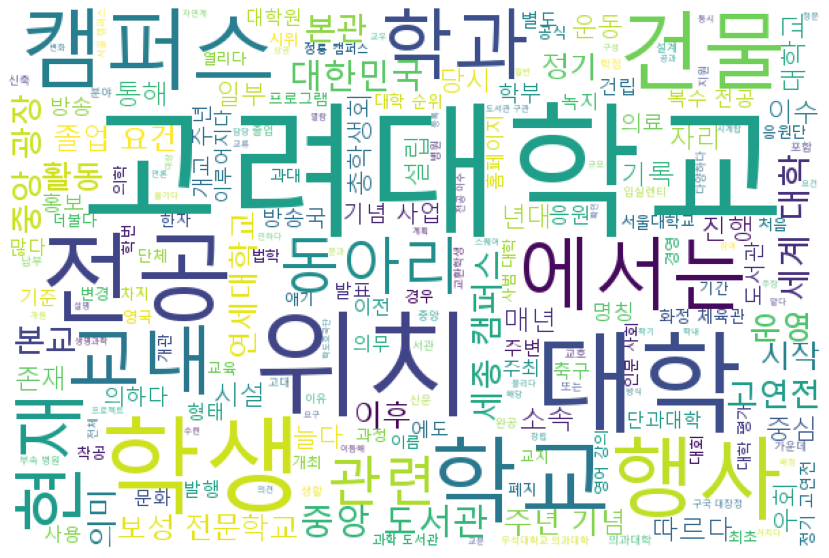

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.make_wordcloud_entire()

### 7. topic_modeling(summary_model)
요약문을 토대로 토픽 모델링을 해주는 함수이다. 최적의 토픽 개수를 함수 내에서 찾아서 학습한다.

워드클라우드와 마찬가지의 이유로 전체 text를 토대로 토픽 모델링을 하는 `topic_modeling_entire`도 있다.

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.topic_modeling('ainize')

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.044492 -0.031114       1        1  11.609495
12    -0.085001 -0.085360       2        1  11.229437
0     -0.112902  0.126955       3        1  10.624348
9     -0.014498 -0.074667       4        1   9.895435
5     -0.126100  0.154035       5        1   7.933138
13    -0.000239 -0.054532       6        1   7.620510
6      0.214439  0.145416       7        1   6.808850
8     -0.009932 -0.000140       8        1   6.765087
4      0.048606 -0.008389       9        1   6.291705
3      0.079491 -0.078160      10        1   5.744817
7      0.034104 -0.026325      11        1   5.204420
11    -0.001893 -0.015567      12        1   4.807330
1     -0.010374 -0.046678      13        1   3.006132
10     0.028791 -0.005475      14        1   2.459294, topic_info=    Term       Freq      Total Category  logprob  loglift
117   전공  15.000000  15.000000  Default  30.0000  30.0000
103   세계   9.000000   9.000000  Default  29.0000  29.0000
310   해당   5.000000   5.000000  Default  28.0000  28.0000
298   복수   5.000000   5.000000  Default  27.0000  27.0000
113   이수   5.000000   5.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
37    관련   0.033007   3.942625  Topic14  -6.8596  -1.0776
285   진행   0.032620   3.410352  Topic14  -6.8714  -0.9443
153   대학   0.034760  20.276363  Topic14  -6.8078  -2.6634
118   졸업   0.033059   4.989440  Topic14  -6.8580  -1.3115
117   전공   0.034026  15.319724  Topic14  -6.8292  -2.4045

[663 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
293       7  0.527839  가능하다
293      11  0.527839  가능하다
404       4  0.952664    가동
393       8  0.514159  가리키다
565      12  0.819581    가미
...     ...       ...   ...
518       9  0.779619    획일
431      10  0.792030    후문
637      12  0.820185    후반
183       1  0.711196    후속
334       5  0.493672    후원

[690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 13, 1, 10, 6, 14, 7, 9, 5, 4, 8, 12, 2, 11])

In [ ]:
kuki = Kukipedia(target_title = "고려대학교")
kuki.topic_modeling_entire()

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.112253 -0.174036       1        1  19.824960
8     -0.157587  0.012886       2        1  18.300296
10    -0.161677  0.005386       3        1  16.897446
3      0.121828  0.132086       4        1  13.332554
6      0.039890  0.076982       5        1   7.388771
1      0.047911  0.076692       6        1   7.362865
7      0.000273 -0.114163       7        1   6.123635
0     -0.075519  0.010957       8        1   3.694343
9      0.017049  0.006586       9        1   3.219005
4      0.014460 -0.064499      10        1   2.584958
2      0.041118  0.031123      11        1   1.271167, topic_info=       Term       Freq      Total Category  logprob  loglift
190      전공  43.000000  43.000000  Default  30.0000  30.0000
135     도서관  34.000000  34.000000  Default  29.0000  29.0000
192      졸업  21.000000  21.000000  Default  28.0000  28.0000
1098    동아리  16.000000  16.000000  Default  27.0000  27.0000
134      대학  57.000000  57.000000  Default  26.0000  26.0000
...     ...        ...        ...      ...      ...      ...
0     고려대학교   0.615021  49.749358  Topic11  -4.5139  -0.0279
216     에서는   0.317376  23.356639  Topic11  -5.1754   0.0667
19       학교   0.312677  24.705434  Topic11  -5.1903  -0.0044
559      정릉   0.031640   4.188320  Topic11  -7.4811  -0.5204
553      위치   0.035991  40.007384  Topic11  -7.3523  -2.6483

[621 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
161       1  0.698712  가능하다
161       2  0.139742  가능하다
571       2  0.354705    가동
571       7  0.354705    가동
1339      5  0.490532    가미
...     ...       ...   ...
717       2  0.199947    회장
717       6  0.799789    회장
199       1  0.508292    획득
126       5  0.490764    휴교
47        3  0.855842    흡수

[916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 11, 4, 7, 2, 8, 1, 10, 5, 3])